In [17]:
import os, pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as sds
import scipy.stats as sts

In [5]:
data = pd.read_csv("Datasets/concrete.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

Trenujemy nie do końca standardowy model random forest. Zwiększamy liczbę estymatorów (drzew) i obniżamy liczbę features w każdym losowaniu. Chodzi o to aby każda zmienna miała szansę

In [6]:
model = RFR(max_features=3,n_estimators=400)
model.fit(X.values,y)
y_hat = model.predict(X.values)
print(metrics.mean_squared_error(y,y_hat,squared=False))

1.8845593559944407


In [7]:
from shap import explainers as Exp
import shap

Używamy niezależnego od modelu explainera opartego o permutację. Są jeszcze inne: kernel (analizuje kernele dla SVM, tree/partition analizuje poszczególne drzewa, neural network - analizauje sieć). Permutacje oparte są o teorię gier. (WYJAŚNIĆ)

In [10]:
explainer = shap.explainers.Permutation(model.predict, X.values) # X masker


Do wyjaśnienia pojedynczej instancji użyjemy explainera z obniżoną liczbą permutacji do 22. W wyniku otrzymujemy krotkę: values: shapely values, base: predykcja dla średnich, data: orginalne dane

In [44]:
shap_values = explainer(X.values[:1],max_evals=22,error_bounds=True)
shap_values

.values =
array([[19.99965676, -0.76581722,  2.07219952,  6.89263185,  1.12060344,
         0.76745131,  3.66336933,  5.57910401]])

.base_values =
array([34.50845099])

.data =
array([[ 540. ,    0. ,    0. ,  162. ,    2.5, 1040. ,  676. ,   28. ]])

Najprostrza forma wizualizacji poejdynczej instancji to waterfall diagram. Pokazuje od wartości średniej zmiany wprowadzane przez każdą zmienną. 

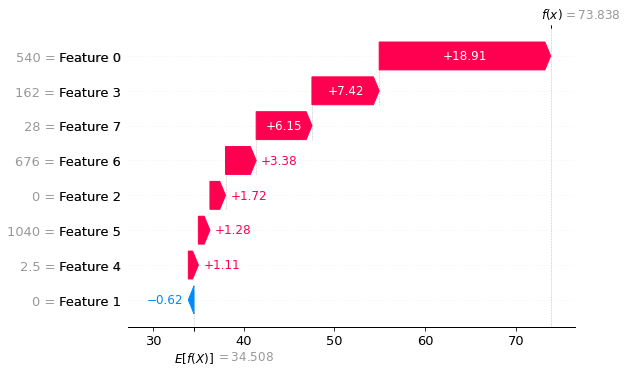

In [40]:
shap.plots.waterfall(shap_values[0])

Problemem modelowania przy pomocy shapely values są interakcje (zależności) pomiędzy zmiennymi: zmienne mogą być skorelowane oraz mniej lub bardziej podobne do siebie (grupowanie zmiennych)

In [18]:
np.corrcoef(X.values)

array([[1.        , 0.9999613 , 0.94486263, ..., 0.89812541, 0.90935908,
        0.94426439],
       [0.9999613 , 1.        , 0.94600496, ..., 0.89859026, 0.91016729,
        0.94409292],
       [0.94486263, 0.94600496, 1.        , ..., 0.91485756, 0.93882153,
        0.93441036],
       ...,
       [0.89812541, 0.89859026, 0.91485756, ..., 1.        , 0.99146625,
        0.99043566],
       [0.90935908, 0.91016729, 0.93882153, ..., 0.99146625, 1.        ,
        0.98470911],
       [0.94426439, 0.94409292, 0.93441036, ..., 0.99043566, 0.98470911,
        1.        ]])

Do grupowania użyjemy miary kosinusowej, bo jest to bardzo długi wektor

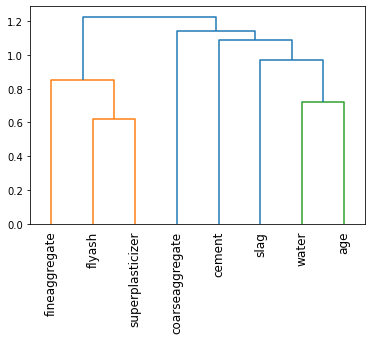

In [25]:
clustering = shap.utils.hclust(scale(X.values), metric="cosine",linkage="average")
fig, ax = plt.subplots(1,1,figsize=(6,4))
dendr = sch.dendrogram(clustering,labels=X.columns,ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [26]:
masker_corr = shap.maskers.Partition(X.values,clustering="correlation")
masker_clust = shap.maskers.Partition(X.values,clustering=clustering)

In [27]:
explainer_corr = shap.explainers.Partition(model.predict, masker_corr)
explainer_clust = shap.explainers.Partition(model.predict, masker_clust)

In [ ]:
shap_values_corr = explainer_corr(X.values[:1])
shap_values_clust = explainer_clust(X.values[:1])

pd.DataFrame({'corr':shap_values_corr.values[0],'clust':shap_values_clust.values[0]},index=X.columns)


Wpływ poszczególnych zmiennych różni się w zalezności od użytego modelu, ale....

In [36]:
pd.DataFrame({'X':shap_values.values[0],'corr':shap_values_corr.values[0],'clust':shap_values_clust.values[0]},index=X.columns)

,X,corr,clust
cement,18.908081,18.575748,18.687369
slag,-0.620714,-0.261237,-0.672622
flyash,1.716538,1.625421,1.796520
water,7.415227,8.033008,6.993024
superplasticizer,1.106323,1.068805,1.377454
coarseaggregate,1.276310,0.999194,1.566514
fineaggregate,3.377455,3.339468,3.682198
age,6.149979,5.948791,5.898742


Jeżeli zastosujemy ten sam model (bez interakcji) z minimalną liczbą permutacji (tu 17, 2* liczba zmiennych +1) to zobaczymy że za każdym razem otrzymujemy inne wartości. Wynika to wprost z teorii gier.

In [61]:
shap_arr = []
for i in range(30):
    shap_arr.append(explainer(X.values[:1],max_evals=17).values[0]) # 8 * 2 + 1
shap_arr = np.array(shap_arr)
pd.DataFrame({'mean':shap_arr.mean(axis=0),'std':shap_arr.std(axis=0)},index=X.columns)

,mean,std
cement,18.683511,0.802707
slag,-0.556720,0.334697
flyash,1.685533,0.288551
water,7.395181,0.697003
superplasticizer,1.072588,0.381055
coarseaggregate,1.354169,0.582679
fineaggregate,3.396426,0.387225
age,6.298511,0.554540


Ale ten sam zabieg dla modeli z interakcją, pokazuje że odchylenie standardowe jest zerowe, co oznacza że za każdym razem otrzymujemy tę samą wartość. Wynika to z faktu, że wartości pomiędzy zmiennymi o dużym podobieństwie są uśredniane.

In [62]:
shap_arr = []
for i in range(30):
    shap_arr.append(explainer_corr(X.values[:1],max_evals=17).values[0]) # 8 * 2 + 1
shap_arr = np.array(shap_arr)
pd.DataFrame({'mean':shap_arr.mean(axis=0),'std':shap_arr.std(axis=0)},index=X.columns)

,mean,std
cement,16.270918,0.000000e+00
slag,-0.261237,0.000000e+00
flyash,2.011231,1.332268e-15
water,8.033008,5.329071e-15
superplasticizer,2.011231,1.332268e-15
coarseaggregate,4.626408,8.881784e-16
fineaggregate,2.011231,1.332268e-15
age,4.626408,8.881784e-16


In [63]:
shap_arr = []
for i in range(30):
    shap_arr.append(explainer_clust(X.values[:1],max_evals=17).values[0]) # 8 * 2 + 1
shap_arr = np.array(shap_arr)
pd.DataFrame({'mean':shap_arr.mean(axis=0),'std':shap_arr.std(axis=0)},index=X.columns)

,mean,std
cement,16.117883,3.552714e-15
slag,4.929543,8.881784e-16
flyash,1.586987,1.110223e-15
water,4.929543,8.881784e-16
superplasticizer,1.586987,1.110223e-15
coarseaggregate,1.566514,1.110223e-15
fineaggregate,3.682198,2.220446e-15
age,4.929543,8.881784e-16


In [66]:
shap_values = explainer(X[:30],max_evals=100,error_bounds=True)


Permutation explainer: 31it [00:10, 10.25s/it]                


Biblioteka shap osiada kilka bardzo dobrze zaprojektowanych wykresów:

1. Zależność pomiędzy zmienną a wpływem

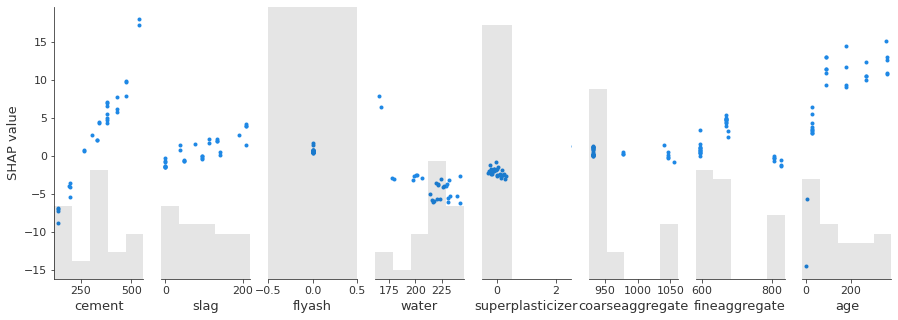

In [72]:
shap.plots.scatter(shap_values)

Globalny wpływ poszczególnych zmiennych

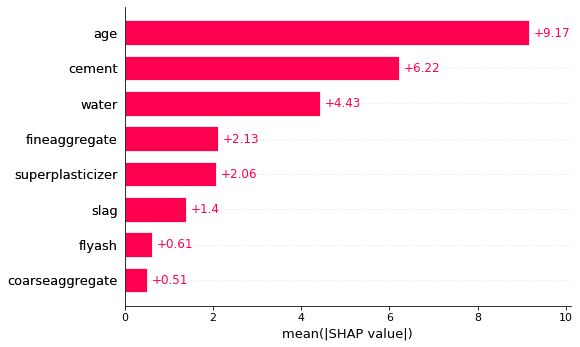

In [76]:
shap.plots.bar(shap_values)

Wykonanie podsumowania

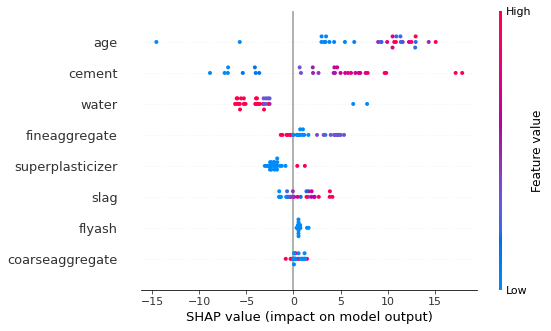

In [80]:
shap.summary_plot(shap_values)

Możliwość porównywania poszczególnych instancji, uwaga jest z tym problem. 

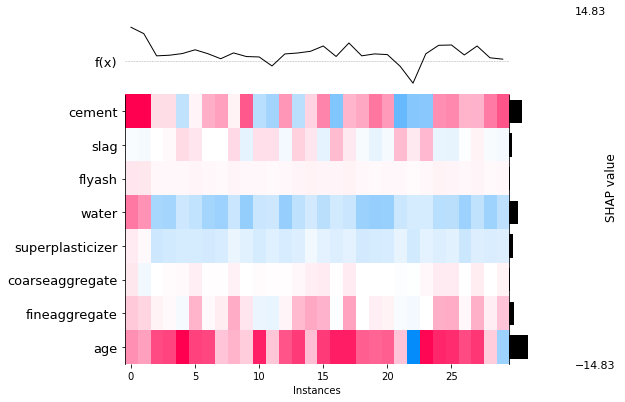

In [83]:
shap.plots.heatmap(shap_values,instance_order=np.arange(30),feature_order=np.arange(8))

W przypadku danych domyślnych, instancje są pożądkowane na podstawie analizy hierarchicznej, ale ich etykiety nie, więc nie wiadomo czego dotyczą wartości

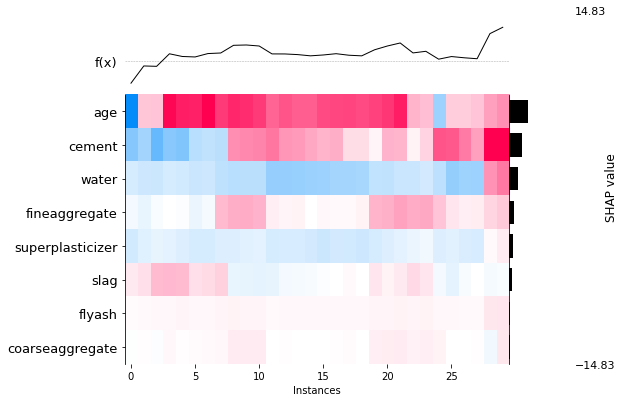

In [82]:
shap.plots.heatmap(shap_values) 